# Определение возраста покупателей

Проект: оценка возраста по фото (регрессия, MAE)

Данные: загрузить фото с метками, выровнять лица, аугментация.

Разбиение: train/val/test (например, 70/15/15) с равномерным покрытием возрастов.

Модель: transfer learning (ResNet/MobileNet) с головой для регрессии.

Обучение и проверка: оптимизировать MAE, подобрать гиперпараметры, оценить на тесте.

## Исследовательский анализ данных

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import matplotlib.pyplot as plt


In [ ]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


In [ ]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
labels.shape[0]

7591

Довольно большое количество фотографий, так что вероятно этого хватит, чтобы получить приемлимую метрику.

In [ ]:
labels['real_age'].value_counts().head(10)

30    317
25    315
27    229
26    226
28    217
23    213
24    211
18    193
16    193
19    180
Name: real_age, dtype: int64

Больше всего изображений 30 и 25 летних людей.

In [ ]:
labels['real_age'].value_counts().tail(10)

78     3
81     3
83     3
88     3
95     2
96     2
93     1
100    1
91     1
97     1
Name: real_age, dtype: int64

Меньше всего когда возраст уже за 90.

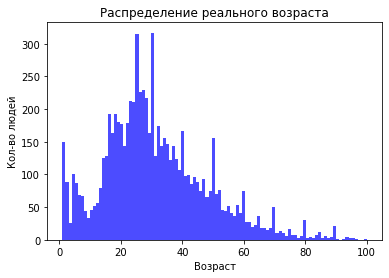

In [ ]:

plt.hist(labels['real_age'], bins=100, alpha=0.7, color='blue')

plt.title('Распределение реального возраста')
plt.xlabel('Возраст')
plt.ylabel('Кол-во людей')

plt.show()

На графике видны две башни, как уже известно это 25 летние и 30 летние, также можно заметить что в начале у нас резкая яма примерно на 9 годах.

In [ ]:
len(labels[labels['real_age'] == 10])

45

In [ ]:
len(labels[labels['real_age'] == 9])

34

In [ ]:
len(labels[labels['real_age'] == 8])

44

Что из этого следует? Возраст людей старшего поколения, а так же возраст детей около 10 лет модель будет определять вероятно хуже из-за малого кол-ва примеров. Так же яма есть на отметке 3-х лет, что тоже не есть хорошо.

In [ ]:
x, y = next(train_gen_flow)

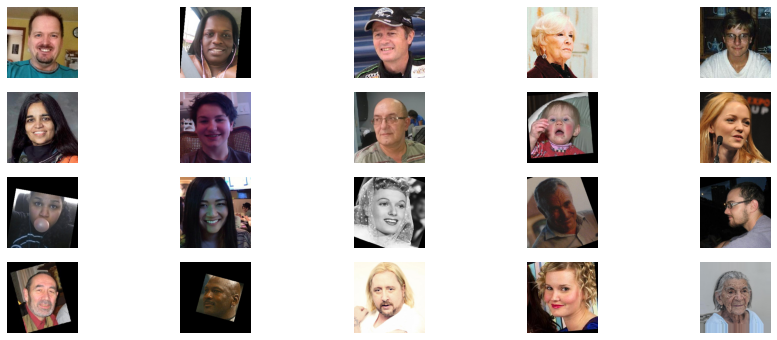

In [ ]:
plt.figure(figsize=(15, 3 * 2))

for i in range(20):
    plt.subplot(4, 5, i + 1)
    plt.imshow(x[i])
    plt.axis('off')

Заметны преобразования фотографий повороты на n градусов, чб фотографии, увеличение и уменьшение фотографий.

Так как у нас есть довольно сильно измененные фотографии, то в случае аугментации не стоит поворачивать фотографии на много градусов, а также разворот по вертикали будет бессмысленным так как задача с лицами, зачем путать модель перевернутыми?

### Вывод

Размер датасета - 7591 изображение. Наибольшие возрастные группы это 30 и 25 лет, наименьшие - за 90. Так же заметим, что от 0 до 20 лет есть некоторые группы (3 года, 9 лет), где изображений довольно мало. Изображения на входе подготовлены (некоторые развернуты, c увеличенным масштабом, с уменьшенным масштабом), также наблюдаются черно-белые изображения. Несмотря на некоторые минусы, размер датасета позволяет построить сеть и в теории получить высокое качество по метрикам.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50
import numpy as np
import pandas as pd

def load_test(path):
    directory=path + 'final_files/'
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(
        validation_split=0.25,
        rescale=1. / 255)
    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=directory,
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='validation',
            seed=12345)



    return train_gen_flow


def load_train(path):
    directory=path + 'final_files/'
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(rescale=1./255,
        horizontal_flip=True,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.2,
        validation_split=0.25)
    train_gen_flow = train_datagen.flow_from_dataframe(
            dataframe=labels,
            directory=directory,
            x_col='file_name',
            y_col='real_age',
            target_size=(224, 224),
            batch_size=32,
            class_mode='raw',
            subset='training',
            seed=12345)



    return train_gen_flow

def create_model(input_shape):
    optimizer = Adam(learning_rate=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    backbone.trainable = True

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_absolute_error'])

    return model

def train_model(model, train_datagen_flow, val_datagen_flow, batch_size=None, epochs=10,
                    steps_per_epoch=None, validation_steps=None):

    model.fit(train_datagen_flow,
              validation_data=val_datagen_flow,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2024-04-09 11:35:46.815869: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-04-09 11:35:47.341175: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 114s - loss: 234.8305 - mean_absolute_error: 11.0693 - val_loss: 624.2382 - val_mean_absolute_error: 20.0016
Epoch 2/10
178/178 - 97s - loss: 92.4499 - mean_absolute_error: 7.2412 - val_loss: 596.2416 - val_mean_absolute_error: 19.3934
Epoch 3/10
178/178 - 104s - loss: 72.0433 - mean_absolute_error: 6.4482 - val_loss: 438.8193 - val_mean_absolute_error: 15.9857
Epoch 4/10
178/178 - 102s - loss: 64.5434 - mean_absolute_error: 6.1223 - val_loss: 224.1849 - val_mean_absolute_error: 11.3644
Epoch 5/10
178/178 - 106s - loss: 50.6939 - mean_absolute_error: 5.4809 - val_loss: 126.7596 - val_mean_absolute_error: 8.6251
Epoch 6/10
178/178 - 103s - loss: 43.9710 - mean_absolute_error: 5.1115 - val_loss: 80.5590 - val_mean_absolute_error: 6.5868
Epoch 7/10
178/178 - 102s - loss: 38.0454 - mean_absolute_error: 4.7671 - val_loss: 77.0170 - val_mean_absolute_error: 6.3774
Epoch 8/10
178/178 - 105s - loss: 33.7512 - mean_absolute_error: 4.5220 - val_loss: 100.0630 - val_mean_absolute_error: 7.4948
Epoch 9/10
178/178 - 103s - loss: 29.7463 - mean_absolute_error: 4.2357 - val_loss: 73.7774 - val_mean_absolute_error: 6.3768
Epoch 10/10
178/178 - 104s - loss: 27.7689 - mean_absolute_error: 4.0746 - val_loss: 66.4594 - val_mean_absolute_error: 5.9506
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 66.4594 - mean_absolute_error: 5.9506
Test MAE: 5.9506

```

## Анализ обученной модели

- Судя по всему модель не переобучилась, так как лосс стабильно уменьшался.
- Обу
- В ходе обучения мы использовали готовые предобученные веса ResNet50, но их мы не замораживали, а дообучали.
- Максимум на 8-й эпохе валид лосс чуть увеличился, что может быть погрешностью.
- Достигли MAE в 5.95, чем решили задачу.